In [1]:
%load_ext autoreload
%autoreload 2

!pip install tinydb

In [2]:
from dataclasses import dataclass
from itertools import product
from typing import List
from typing import Optional

import matplotlib.pyplot as plt
from matplotlib.axis import Axis
import numpy as np
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from tinydb import TinyDB, Query
from tinydb.storages import MemoryStorage
from tinydb.table import Table

from kyle.evaluation.reliabilities import (
    expected_calibration_error,
    class_wise_expected_calibration_error,
)

## Case 1: RF and MLP on Synthetic Data

Here the sample size is increased by simply including more synthetic data

In [3]:
n_samples = 15000
n_classes = 4

In [4]:
n_features = 20
n_informative = 7
n_redundant = 10

X, y = datasets.make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=n_redundant,
    n_classes=n_classes,
    random_state=42,
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=42
)

print(f"Training set size: {len(X_train)}, calibration set size: {len(X_test)}")

Training set size: 3000, calibration set size: 12000


In [5]:
MODELS = {
    "mlp": MLPClassifier(hidden_layer_sizes=(30, 30, 20), max_iter=500),
    "rf": RandomForestClassifier(),
}

predicted_confs = {}

for model_name, model in MODELS.items():
    print(f"Fitting {model_name} on {len(X_train)} samples.")
    model.fit(X_train, y_train)

    confs = model.predict_proba(X_test)
    predicted_confs[model_name] = confs
    y_pred = confs.argmax(axis=1)
    model_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy of {model_name}: {model_accuracy}")

Fitting mlp on 3000 samples.


Test accuracy of mlp: 0.86575
Fitting rf on 3000 samples.


Test accuracy of rf: 0.8706666666666667


In [6]:
# Consistency resampling to get calibrated classifiers

calibrated_y_true = {
    "mlp": np.zeros(len(X_test)),
    "rf": np.zeros(len(X_test)),
}
for model, confs in predicted_confs.items():
    for i, conf in enumerate(confs):
        calibrated_y_true[model][i] = np.random.choice(n_classes, p=conf)

In [7]:
METRICS = {
    "ECE": expected_calibration_error,
    "cwECE": class_wise_expected_calibration_error,
}


def get_scores(
    evaluation_set_size: int,
    num_samples: int,
    model: str,
    metric: str,
    consistency_resampling=False,
):
    results = []
    for _ in range(num_samples):
        sample_indices = np.random.choice(
            len(X_test), evaluation_set_size, replace=False
        )
        confs = predicted_confs[model][sample_indices]
        if not consistency_resampling:
            y_true = y_test[sample_indices]
        else:
            y_true = calibrated_y_true[model][sample_indices]
        score = METRICS[metric](y_true, confs)
        results.append(score)
    return np.array(results)

In [8]:
@dataclass
class MetricEvaluation:
    model: str
    metric: str
    n_bins: int
    strategy: int
    scores: Optional[np.ndarray] = None
    set_size: Optional[int] = None
    num_samples: Optional[int] = None
    consistency_resampling: bool = False

    def perform_evaluation(
        self, set_size: int, num_samples: int, consistency_resampling=False
    ):
        self.set_size = set_size
        self.num_samples = num_samples
        self.consistency_resampling = consistency_resampling
        self.scores = get_scores(
            set_size,
            num_samples,
            self.model,
            self.metric,
            consistency_resampling=consistency_resampling,
        )

    def mean(self):
        self._assert_nonempty()
        return self.scores.mean()

    def std(self):
        self._assert_nonempty()
        return self.scores.std()

    def _assert_nonempty(self):
        if self.scores is None:
            raise RuntimeError(
                f"You must run `perform_evaluation` before computing statistics: {self}"
            )

In [9]:
# collect all evaluations to an in-memory database
n_bins_options = [5, 40]
binning_strategy_options = ["uniform", "quantile"]


def save_evaluations_to_db(
    set_sizes: List[int], num_samples: int, db: TinyDB, consistency_resampling=False
):
    for set_size, model, metric, n_bins, strategy in product(
        set_sizes, MODELS, METRICS, n_bins_options, binning_strategy_options
    ):
        metric_evaluation = MetricEvaluation(model, metric, n_bins, strategy)
        metric_evaluation.perform_evaluation(
            set_size, num_samples, consistency_resampling=consistency_resampling
        )
        db.insert(metric_evaluation.__dict__)

In [10]:
# customization of tinydb
class EvaluationsTable(Table):
    def search(self, cond: Query) -> List[MetricEvaluation]:
        results = super().search(cond)
        return [MetricEvaluation(**eval_dict) for eval_dict in results]


TinyDB.table_class = EvaluationsTable
TinyDB.default_storage_class = MemoryStorage

In [11]:
set_sizes = range(500, 8000, 500)
num_samples = 10
db = TinyDB()
evalQ = Query()

In [12]:
save_evaluations_to_db(
    set_sizes=set_sizes,
    num_samples=num_samples,
    db=db,
    consistency_resampling=False,
)

save_evaluations_to_db(
    set_sizes=set_sizes,
    num_samples=num_samples,
    db=db,
    consistency_resampling=True,
)

In [13]:
def get_query(
    model: str,
    n_bins: int = None,
    strategy: str = None,
    metric: str = None,
    consistency_resampling=False,
):
    q = evalQ.model == model
    q = q & (evalQ.consistency_resampling == consistency_resampling)
    if n_bins:
        q = q & (evalQ.n_bins == n_bins)
    if strategy:
        q = q & (evalQ.strategy == strategy)
    if metric:
        q = q & (evalQ.metric == metric)
    return q


def get_evaluations(
    model: str,
    n_bins: int = None,
    strategy: str = None,
    metric: str = None,
    consistency_resampling=False,
) -> List[MetricEvaluation]:
    evaluations = db.search(
        get_query(
            model,
            n_bins,
            strategy,
            metric,
            consistency_resampling=consistency_resampling,
        )
    )
    return sorted(evaluations, key=lambda ev: ev.set_size)

In [14]:
def plot_convergence(
    model: str,
    n_bins: int,
    strategy: str,
    metric: str,
    consistency_resampling=False,
    delta_x=0,
    color=0,
    ax: Axis = None,
):
    selected_evaluations = get_evaluations(
        model, n_bins, strategy, metric, consistency_resampling
    )

    selected_set_sizes = np.zeros(len(selected_evaluations))
    means = np.zeros(len(selected_evaluations))
    stds = np.zeros(len(selected_evaluations))
    for i, ev in enumerate(selected_evaluations):
        selected_set_sizes[i] = ev.set_size
        means[i] = ev.mean()
        stds[i] = ev.std()

    if isinstance(color, int):
        color = f"C{color}"
    x_values = selected_set_sizes + delta_x
    ymin = means - stds
    ymax = means + stds
    if ax is None:
        ax = plt.gca()
    title = f"{metric} for model: {model}"
    if consistency_resampling:
        title += f" (cons-res. labels)"
    ax.set_title(title)
    ax.set_xlabel("sample size")
    ax.plot(x_values, means, ".", color=color, label=f"{n_bins} bins, {strategy}")
    ax.vlines(x_values, ymin=ymin, ymax=ymax, color=color, linewidth=2)
    return ax


def plot_all_convergences(
    model: str, metric: str, ax: Axis = None, delta_x=60, consistency_resampling=False
):
    for i, (n_bins, strategy) in enumerate(
        product(n_bins_options, binning_strategy_options)
    ):
        ax = plot_convergence(
            model,
            n_bins,
            strategy,
            metric,
            delta_x=i * delta_x,
            color=i,
            ax=ax,
            consistency_resampling=consistency_resampling,
        )
    ax.legend()
    return ax

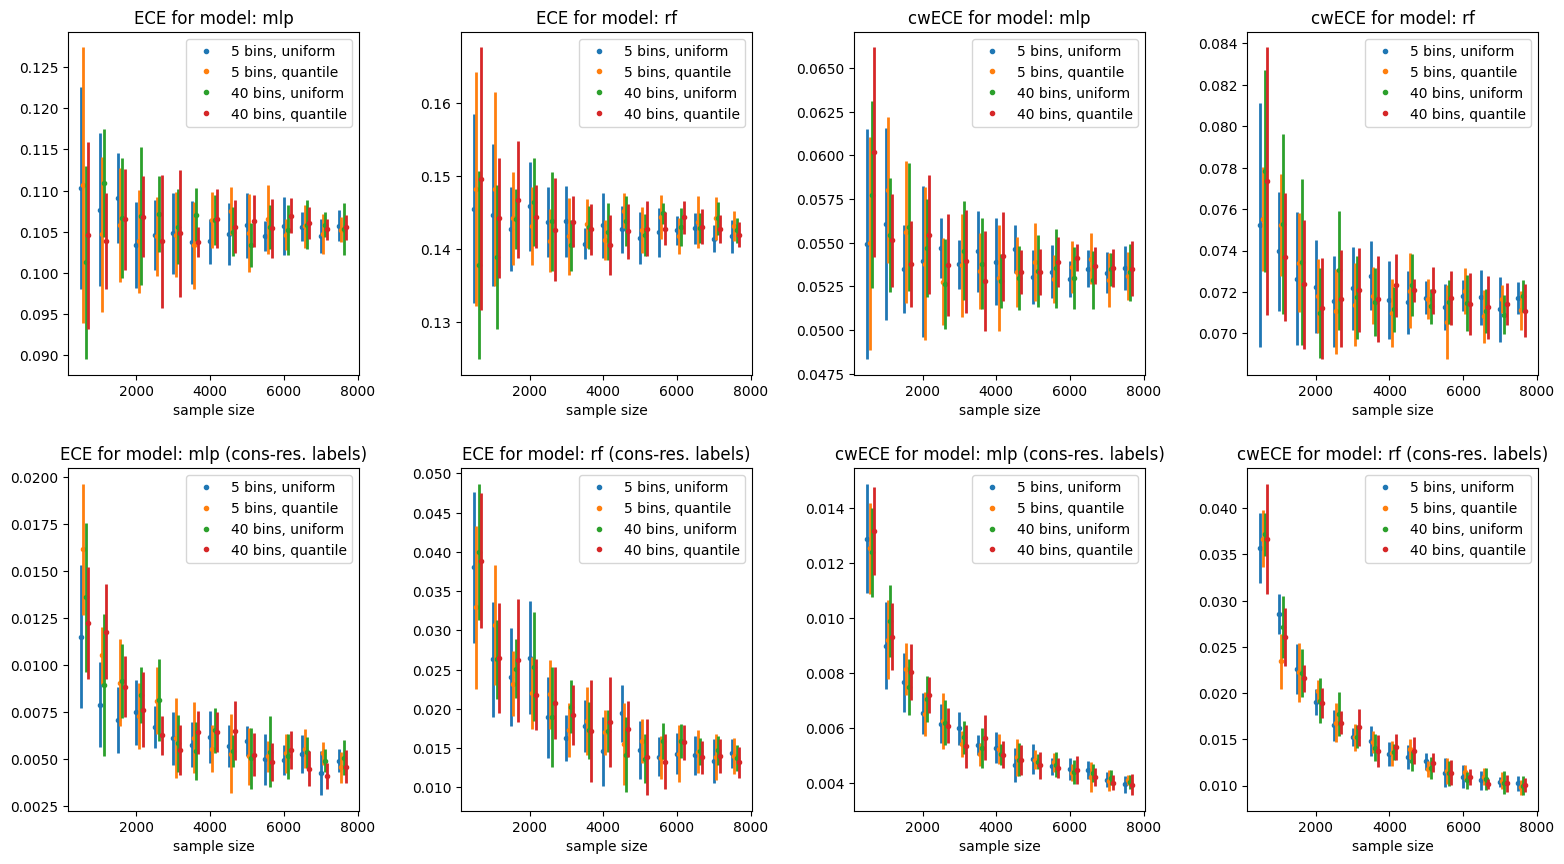

In [15]:
def to_win_path(path: str):
    return path.replace("/c/", "C:\\").replace("/", "\\")


fig, axs = plt.subplots(2, 4, figsize=(16, 9))

plot_all_convergences("mlp", "ECE", ax=axs[0, 0])
plot_all_convergences("rf", "ECE", ax=axs[0, 1])
plot_all_convergences("mlp", "cwECE", ax=axs[0, 2])
plot_all_convergences("rf", "cwECE", ax=axs[0, 3])
plot_all_convergences("mlp", "ECE", consistency_resampling=True, ax=axs[1, 0])
plot_all_convergences("rf", "ECE", consistency_resampling=True, ax=axs[1, 1])
plot_all_convergences("mlp", "cwECE", consistency_resampling=True, ax=axs[1, 2])
plot_all_convergences("rf", "cwECE", consistency_resampling=True, ax=axs[1, 3])

fig.tight_layout(pad=2.0)
plt.show()